# LSTM
### Kerasで実装
参照サイト：https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

#### データの前処理

In [1]:
import numpy as np
import pandas as pd
np.random.seed(443)
import copy
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams

In [2]:
## データセット
DATA = pd.read_csv("metar_for_lstm.csv", index_col=0)

In [3]:
DATA.columns

Index(['VIS', 'WDIR', 'WSPD', 'GUST', 'RA', 'DZ', 'SN', 'CLD', 'CIG', 'TMP',
       'DEW', 'TmTD', 'PRES'],
      dtype='object')

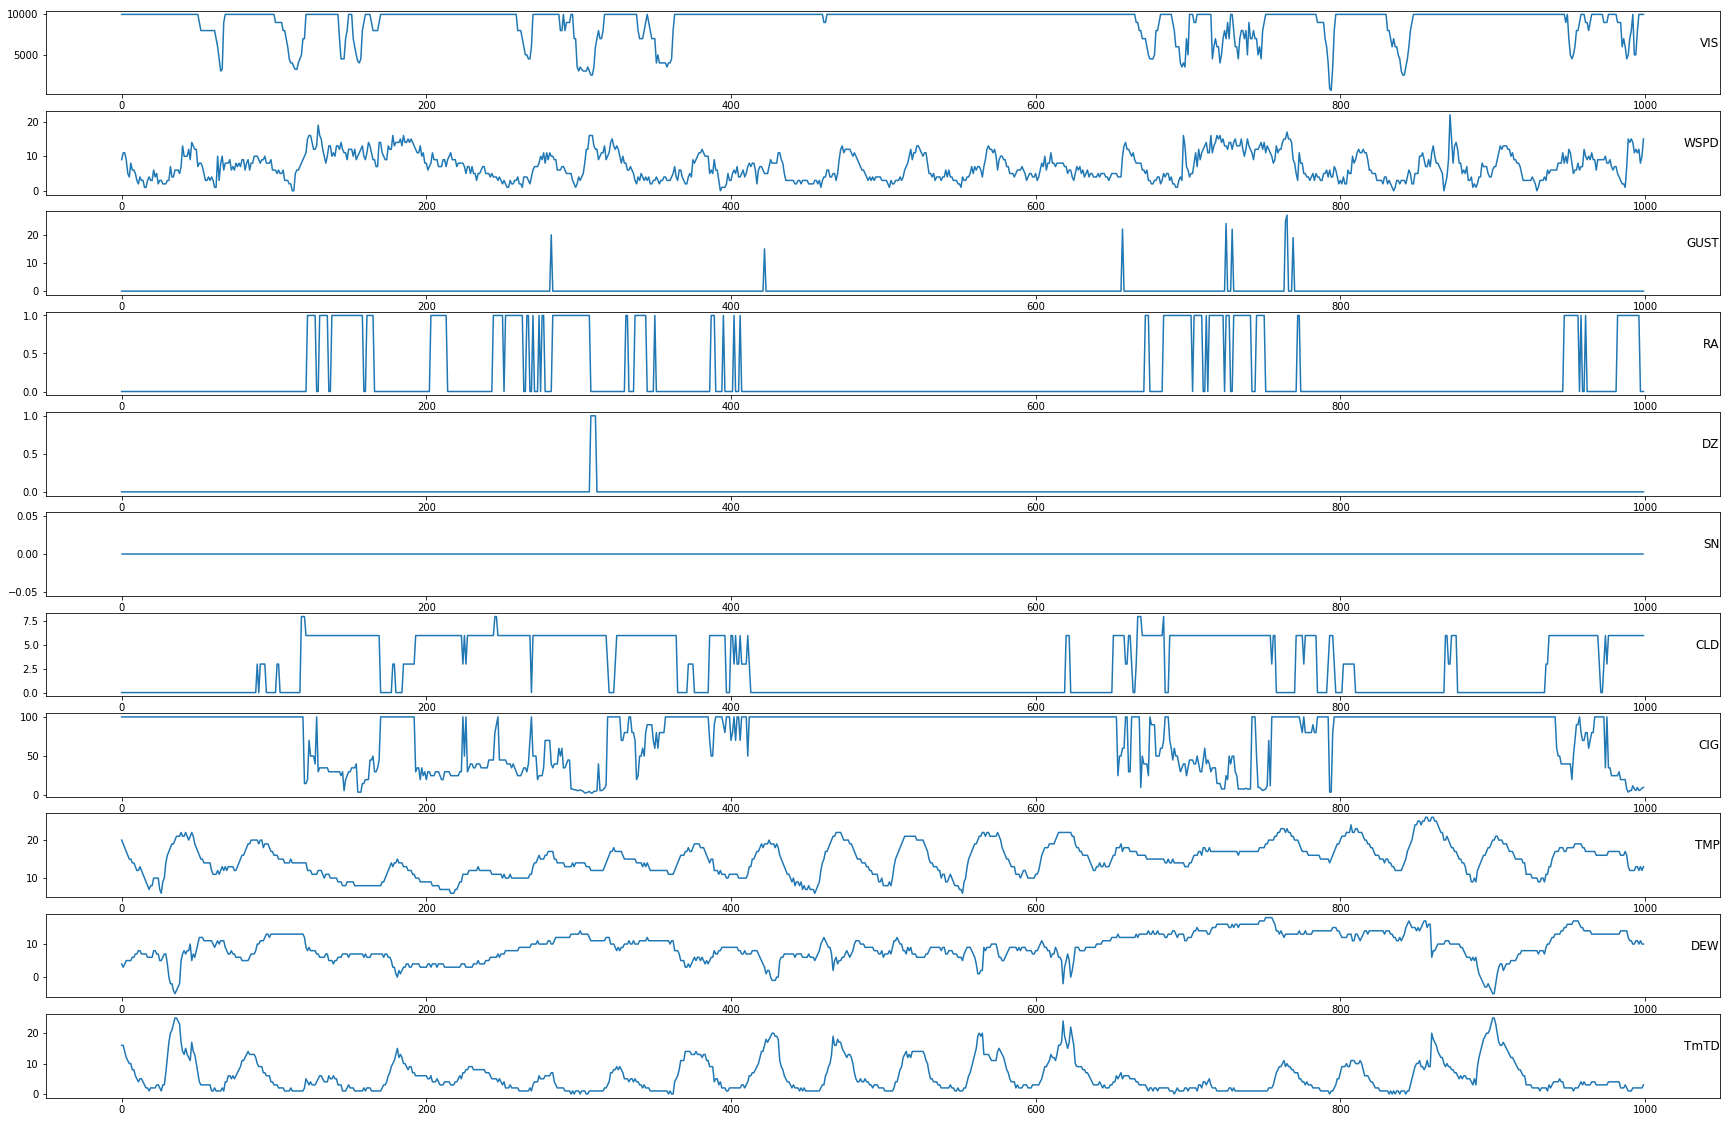

In [4]:
## 描画
rcParams['figure.figsize'] = 30,20
values = DATA[5000:6000].values
# specify columns to plot
groups = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(DATA.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [5]:
## モデル投入前のデータ整形
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
## ダミー変数
cat_val = ['WDIR']
DATA = pd.get_dummies(data=DATA, columns=cat_val)

## 視程は対数をとる
def Log_VIS(x):
    vis = copy.deepcopy(x)
    vis[ vis==0 ] = 50
    return np.log( vis )

DATA.VIS = Log_VIS( DATA.VIS )

## 連続量は正規化（0〜1）
scaler = MinMaxScaler(feature_range=(0, 1))
DATA_S = scaler.fit_transform( DATA )

In [7]:
# frame as supervised learning
reframed = series_to_supervised(DATA_S, 1, 3)

# drop columns we don't want to predict
reframed.drop(reframed.columns[21:63], axis=1, inplace=True)
reframed.drop(reframed.columns[22:], axis=1, inplace=True)
print(reframed.columns)

# split into train and test sets
values = reframed.values
TRAIN = values[:25000, :]
DEV = values[25000:35014, :]
TEST = values[35014:, :]

# split into input and outputs
train_X, train_y = TRAIN[:, :-1], TRAIN[:, -1]
dev_X, dev_y = DEV[:, :-1], DEV[:, -1]
test_X, test_y = TEST[:, :-1], TEST[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
dev_X = dev_X.reshape((dev_X.shape[0], 1, dev_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var14(t-1)', 'var15(t-1)',
       'var16(t-1)', 'var17(t-1)', 'var18(t-1)', 'var19(t-1)', 'var20(t-1)',
       'var21(t-1)', 'var1(t+2)'],
      dtype='object')


### Kerasで学習

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

from math import sqrt
from sklearn.metrics import mean_squared_error

/Users/calmtree443/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 25000 samples, validate on 10014 samples
Epoch 1/100
 - 2s - loss: 0.0744 - val_loss: 0.0071
Epoch 2/100
 - 1s - loss: 0.0054 - val_loss: 0.0061
Epoch 3/100
 - 1s - loss: 0.0045 - val_loss: 0.0050
Epoch 4/100
 - 1s - loss: 0.0039 - val_loss: 0.0040
Epoch 5/100
 - 1s - loss: 0.0034 - val_loss: 0.0035
Epoch 6/100
 - 1s - loss: 0.0030 - val_loss: 0.0031
Epoch 7/100
 - 1s - loss: 0.0028 - val_loss: 0.0030
Epoch 8/100
 - 1s - loss: 0.0027 - val_loss: 0.0030
Epoch 9/100
 - 1s - loss: 0.0027 - val_loss: 0.0030
Epoch 10/100
 - 1s - loss: 0.0027 - val_loss: 0.0030
Epoch 11/100
 - 1s - loss: 0.0027 - val_loss: 0.0030
Epoch 12/100
 - 1s - loss: 0.0027 - val_loss: 0.0030
Epoch 13/100
 - 1s - loss: 0.0027 - val_loss: 0.0030
Epoch 14/100
 - 1s - loss: 0.0027 - val_loss: 0.0030
Epoch 15/100
 - 1s - loss: 0.0027 - val_loss: 0.0030
Epoch 16/100
 - 1s - loss: 0.0027 - val_loss: 0.0030
Epoch 17/100
 - 1s - loss: 0.0027 - val_loss: 0.0030
Epoch 18/100
 - 1s - loss: 0.0027 - val_loss: 0.0030
Epoch

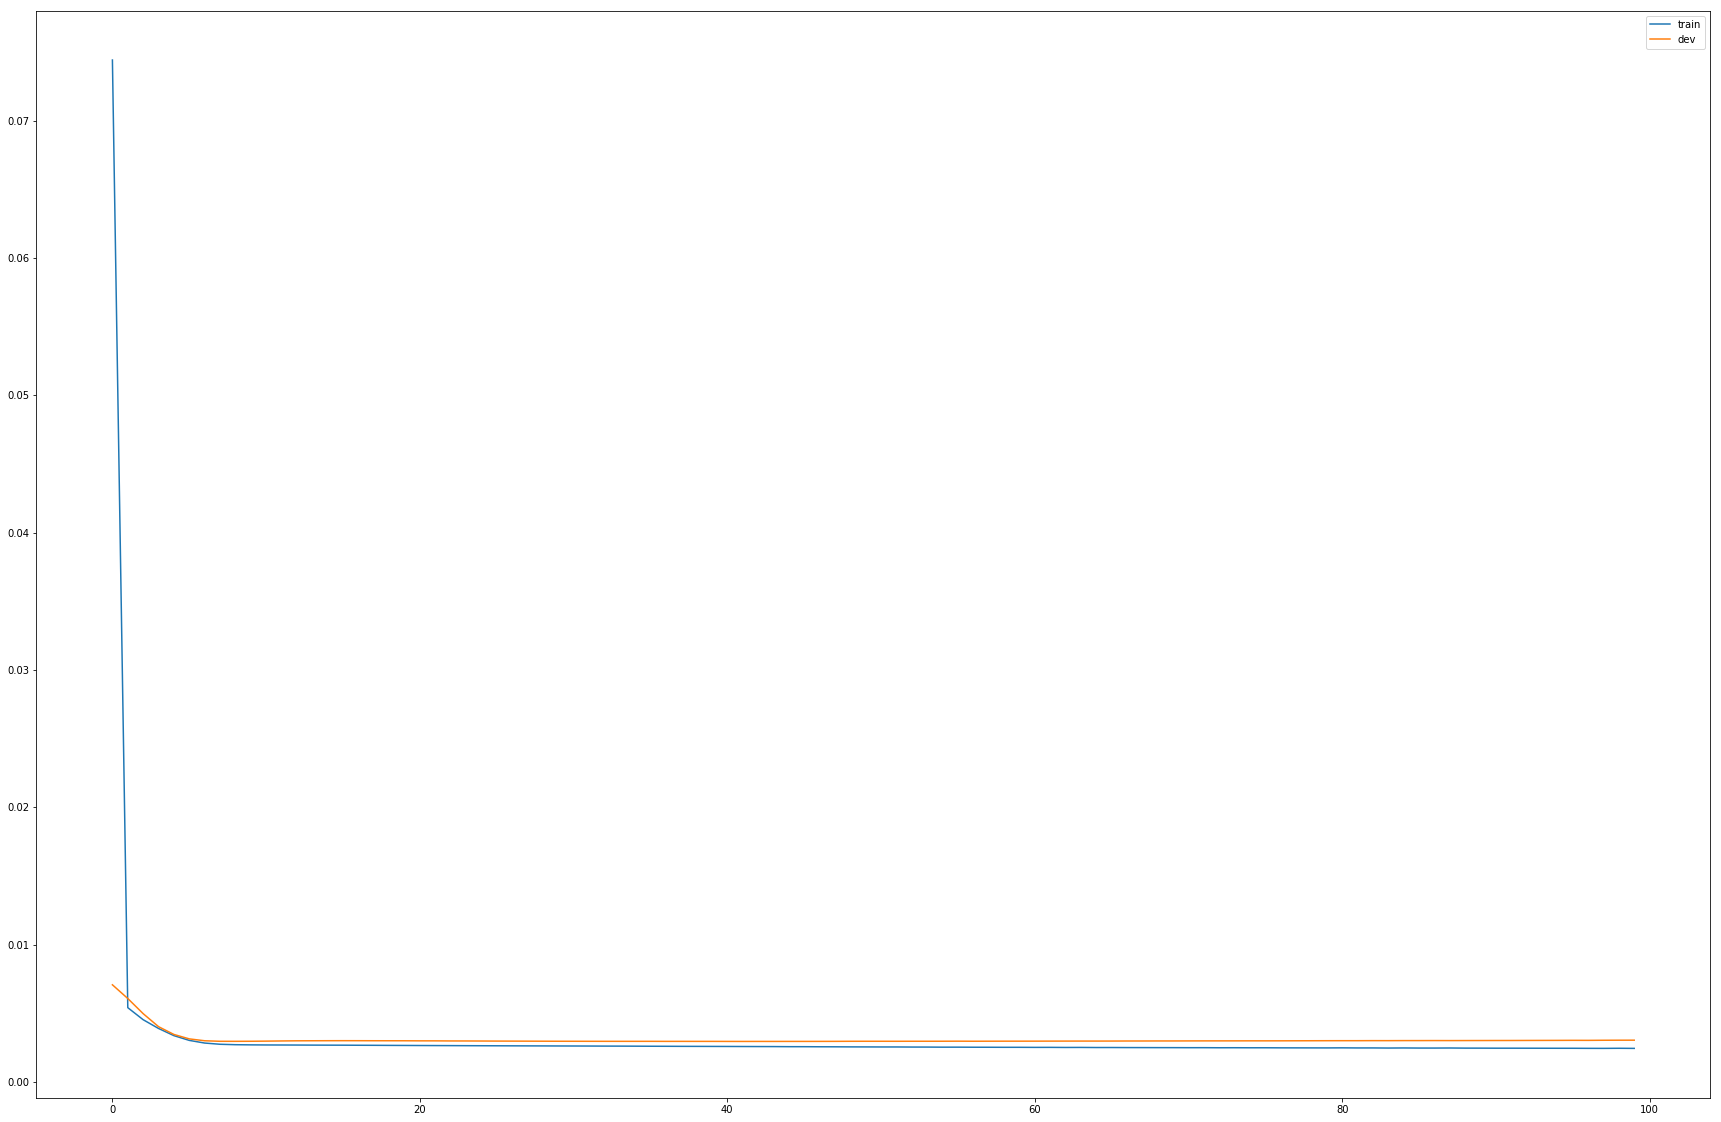

In [12]:
## Keras実行
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Activation('relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(dev_X, dev_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

In [13]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
fcst_vis = np.round( np.exp(inv_yhat[:,0]) )

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
obs_vis = np.round( np.exp(inv_y[:,0]) )

### 評価

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

## カテゴリー評価
def Category_Evaluation(obs_vis, fcst_vis):
    #-Category
    obs_cat = VIS_Category( obs_vis )
    fcst_cat = VIS_Category( fcst_vis )
    matrix = confusion_matrix(y_true=obs_cat, y_pred=fcst_cat)

    print( classification_report(y_true=obs_cat, y_pred=fcst_cat) )
    print( matrix )
    print( "Accuracy : ", accuracy_score( obs_cat, fcst_cat ) )
    print( "F1 average : ", f1_score( obs_cat, fcst_cat, average='macro' ) )
    print( "Weighted F1 : ", Original_Score(matrix) )
    print( "ETS 800m : ", ETS(obs_cat, fcst_cat, 4) )
    print( "BI 800m : ", BI(obs_cat, fcst_cat, 4) )
    print( "ETS 1600m : ", ETS(obs_cat, fcst_cat, 3) )
    print( "BI 1600m : ", BI(obs_cat, fcst_cat, 3) )

## Equitable Threat Score
def ETS(obs_cat, fcst_cat, rank):
    obs_onoff = np.full( len(obs_cat), 0 )
    obs_onoff[ obs_cat >= rank ] = 1
    fcst_onoff = np.full( len(fcst_cat), 0 )
    fcst_onoff[ fcst_cat >= rank ] = 1

    m = confusion_matrix(y_true=obs_onoff, y_pred=fcst_onoff)
    Pc = len(obs_onoff[ obs_onoff == 1 ]) / len(obs_onoff)
    Sf = Pc * ( m[1,1] + m[0,1] ) # ランダム的中率
    ets = ( m[1,1] - Sf ) / ( m[0,1] + m[1,0] + m[1,1] - Sf )
    return ets

## バイアススコア
def BI(obs_cat, fcst_cat, rank):
    obs_onoff = np.full( len(obs_cat), 0 )
    obs_onoff[ obs_cat >= rank ] = 1
    fcst_onoff = np.full( len(fcst_cat), 0 )
    fcst_onoff[ fcst_cat >= rank ] = 1

    m = confusion_matrix(y_true=obs_onoff, y_pred=fcst_onoff)
    bi = m[:,1].sum() / m[1,:].sum()
    return bi

## 視程カテゴリー分け
def VIS_Category(vis):
    cat = np.full( len(vis), 0 )
    cat[ vis < 5000 ] = 1
    cat[ vis < 3200 ] = 2
    cat[ vis < 1600 ] = 3
    cat[ vis < 800 ] = 4
#     cat[ vis < 400 ] = 5
    return cat

## 各カテゴリーの総数の逆数で重み付け
# 低い視程カテゴリーの正解に重みをつけたい
def Original_Score(m):
    F1_score = []
    total = 0
    for i in range( len(m) ):
        if m[:,i].sum() == 0:
            precision = 0
        else:
            precision = m[i,i] / m[:,i].sum()

        if m[i,:].sum() == 0:
            recall = 0
        else:
            recall = m[i,i] / m[i,:].sum()

        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

        if m[i,:].sum() == 0:
            F1_score.append( 0 )
        else:
            F1_score.append( f1 / m[i,:].sum() )
            total += 1 / m[i,:].sum()

    fin_score = sum( F1_score ) / total
    return fin_score

In [15]:
Category_Evaluation( obs_vis, fcst_vis )

             precision    recall  f1-score   support

          0       0.97      0.97      0.97     16094
          1       0.33      0.41      0.37       816
          2       0.44      0.23      0.30       500
          3       0.22      0.13      0.17        82
          4       0.29      0.08      0.12        66

avg / total       0.91      0.92      0.92     17558

[[15674   368    47     2     3]
 [  425   331    53     6     1]
 [  125   246   113    10     6]
 [   11    33    25    11     2]
 [    7    13    21    20     5]]
Accuracy :  0.9188973687208111
F1 average :  0.38439599202056385
Weighted F1 :  0.16250557798415777
ETS 800m :  0.06333518951302321
BI 800m :  0.25757575757575757
ETS 1600m :  0.2134227577878485
BI 1600m :  0.44594594594594594


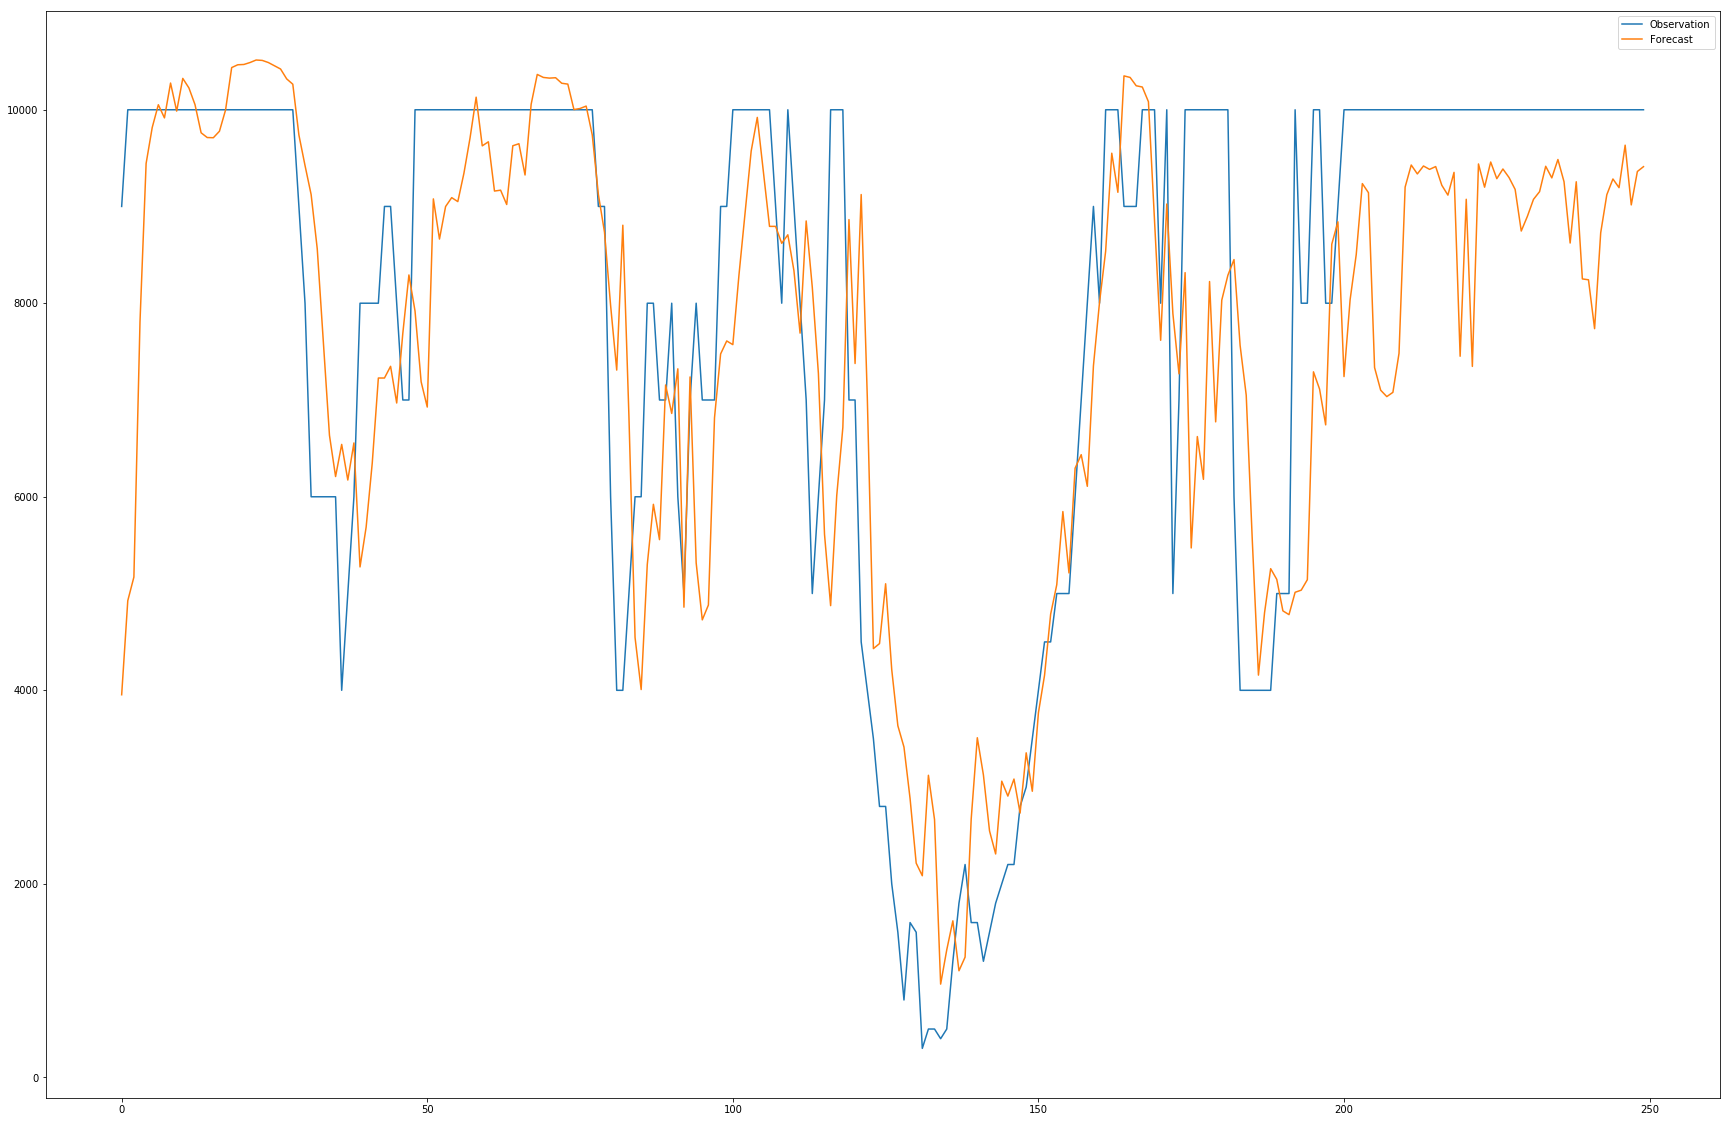

In [18]:
plt.plot(obs_vis[9200:9450], label='Observation')
plt.plot(fcst_vis[9200:9450], label='Forecast')
plt.legend()
plt.show()